# Spine Model


In [1]:
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st
from bootstrap import btset_cd, generateplots, btShInh


# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("Basic2.hoc",axon=False)

# Adding piece of dendritic branch with spine
model.addDend(name="DendE",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="DendE",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="DendN",locus=3,L=240.0,D=0.5,ilocus=1)
data.model = model.__dict__

model.soma.L = 20
model.dend[-1].L = 200
model.dend[-1].diam = 10
print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())


	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 6283.185307179586
Topology:

|-|       soma(0-1)
   `|       dendA1c(0-1)
     `|       dendA1(0-1)
       `|       DendE(0-1)
         `|       DendN(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


In [2]:
nsp = 1000
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

dis['Rneck'] = dis['Rneck']*2
sis['Rneck'] = sis['Rneck']*2
sps['Rneck'] = sps['Rneck']*2
#generateplots(dis,corplot=True)

In [3]:
iPSDsh = btShInh(size=nsp)

In [4]:
rhGABAR = 500 # Receptors/um2
rhAMPAR = 1000 # Receptors/um2
rhNMDAR = 10 # Receptors/um2

gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*3/5.0
gtrN = rhNMDAR*30e-6*1.0/16.0/4.0/1.27*5*50

### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [5]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = 0.5
tau2 = 3.0
AMPA.tau1 = tau1
AMPA.tau2 = tau2

nampa = 50
gmax = 15*nampa/1e6
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
nnmda = 2
gmaxN = 50*nnmda/1e6
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = 2.0
NMDA.tau2 = 30.0


### Inhibitory synapse

In [6]:
nGABA = 35
gmaxG = nGABA*30e-6
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=1.5,tau2=15.0)  

In [7]:
model.dend

[dendA1c, dendA1, dendB1, DendE, DendN]

### Recording places

We set recording vectors in all dendritic compartments, spine included

In [8]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
caDendRec = []
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    caDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica) 
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai) 


Vector[16]

In [9]:
vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)

In [10]:
vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)

In [11]:
model.dend

[dendA1c, dendA1, dendB1, DendE, DendN]

In [12]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]
currentGABA = iRec[1]

In [13]:
currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)

Vector[38]

In [14]:
dendsizeL0 = 10
dendsizeL = max(max(max(dis['Dss'])+10,max(sis['Dss'])+10),178)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.dend[0]
dend.L = dendsizeL0
dend.diam = 1.0
print(dend.L,dend.diam)
Rdend = dend.L*1e-6/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf = Rdend
dend = model.dend[1]
dendc = model.dend[1]
dendc.L = dendsizeL
dend.diam = 0.7
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
dend = model.dend[-2]
dend.diam = 0.7
dendsh = model.dend[-2]
dend.L = 1
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
print("The resistance of neck and the dendritic impedance are %.2f and %2.f MΩ (resp.)" %(Rneck/1e6,Rdend/1e6))

10.0 1.0
185.73159196001026 0.699999988079071 19.098593171027442
1.0 0.7 381.05902528009227
The resistance of neck and the dendritic impedance are 84.88 and 383 MΩ (resp.)


In [15]:
#model.soma.diam = model.soma.L
dendN = model.dend[-1]
dendN.L = 1

In [16]:
dendsh.diam = 0.7
dendc.diam = 0.7
dendN.diam = 0.7        

In [17]:
rhosp = 1.3
dendareaperL = rhosp*mean(sps['Ah'])+(pi*0.5)
factor = dendareaperL/(pi*0.5)
print(factor)
dendN.cm = 3.5
dendc.cm = 3.5


dendN.g_pas = 3.5/model.RM
dendc.g_pas = 3.5/model.RM

3.6216381943356093


In [18]:
dendc.nseg = int(dendc.L//10)+1
dendN.nseg = int(dendN.L//10)+1

dendc.nseg = 10
dendN.nseg = 10
print(dendc.nseg,dendN.nseg)

10 10


In [19]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

## Simulation function


In [20]:
diam0 = 0.15

In [21]:
Rneck = neck.Ra*neck.L/(neck.diam)**2*0.04/pi
print(Rneck)

84.88263631567752


In [22]:
def simulateSet(model,spn,tG = 500,ton = 50,toffset = 50,t_stop = 250, EL = -65,btsr = None,VDCC = array([0.,0,0,0]), dendrec = True):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    neck = model.neck[0]
    sp = model.spne[0]
    dshL = dendsh.L
    dendsizeL = dendsh.L+dendc.L+dendN.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"]))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
         
    nsp = data.shape[0]
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        
        neck.L = data[i,7]  
        Rneck0 = neck.Ra*neck.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck.diam = diam0*sqrt(Rneck0/data[i,3])
        
        posD = data[i,4]
        
        dendc.L = posD-dshL/2
        dendN.L = dendsizeL-posD-dshL/2

        
        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        sp.cm = data[i,8]
        sp.g_pas = data[i,8]/model.RM
        spvol = sp(0.5).volume()
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        
        CaTcond = 1e-3# pS
        sp.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50

        for il in range(10):
            f = 1-7.5*il/dendc.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendc(f)._ref_v)
            else:
                vDendEL[il].record(dendc(0.0)._ref_v)
        
        for il in range(10):
            f = 7.5*il/dendc.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendN(f)._ref_v)
            else:
                vDendEL2[il].record(dendN(1.0)._ref_v)
                
        lb.h.finitialize(model.E_PAS)
        
        

                    
        #print(data[i,:])
        lb.neuron.run(t_stop)
        
        #plot(trec,vspneRec[0])    
        
        current = abs((array(vDendRec[1])-array(vrec[0]))/Rdend)
        
        vtracs[:,i] = array(vspneRec[0]) 
        if dendrec:
            vtracsD[:,i] = array(vDendRec[1])
        else:
            vtracsD[:,i] = array(vDendEL[2])
            
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,max(vDendRec[3])-EL,max(vrec)-EL,max(cat)-cat[0],array(currentGABA)[aG],array(currentAMPA)[aA],spvol,max(current)]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]

        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,array(trec))

In [23]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
EL0 = -70

In [24]:
from bootstrap import dataset
with open("data_Fullset/Fullset.pkl","rb") as f:
    data = pickle.load(f)
spdata = dataset(data,noise=0.0)
spdata['A2'][isnan(spdata['A2'])] = 0.0
#spdata['Rneck'] = 2*spdata['Rneck']

sel = ones(spdata['A2'].shape[0]) == 1
keys = list(spdata.keys())
keys.pop(12)
keys.pop(11)
keys.pop(7)
keys.pop(3)

for key in keys:
    sel = sel*isfinite(spdata[key])
    #print(key,':',sel.sum())
    
for key in spdata.keys():
    spdata[key] = spdata[key][sel]
    print(key,':',isfinite(spdata[key]).sum())

#Bch : 365
Dsb : 365
Dss : 365
d_interSp : 357
Vtot : 365
Vh : 365
Ln : 365
SA : 365
nPSD : 365
A1 : 365
A2 : 365
GPHN SNR : 40
DiS-EMchk : 27
Lneck : 365
maxDneck : 365
minDneck : 365
meanDneck : 365
Rneck : 365
Lhead : 365
maxDhead : 365
minDhead : 365
meanDhead : 365
Ah : 365
Rhead : 365
L : 365
D : 365
AhA0 : 365


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


85.75387461129424 51.45232476677654 171.50774922258847


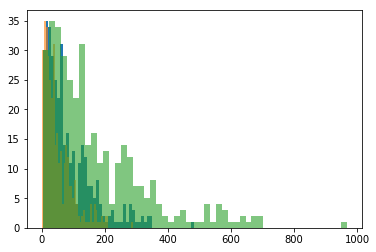

In [25]:
hist(spdata['Rneck'],51)
hist(spdata['Rneck']*1.5/2.5,51,alpha=0.6)
hist(spdata['Rneck']*2,51,alpha=0.6)
print(spdata['Rneck'].mean(),spdata['Rneck'].mean()*1.5/2.5,spdata['Rneck'].mean()*2)

## Check of passive properties of the membrane

 - First we check the total leaking conductance / resistance

In [26]:
AMPA2 = lb.h.Exp2Syn(1,sec = model.soma)
tau1  = 0.1
tau2 = 0.5
AMPA2.tau1 = tau1
AMPA2.tau2 = tau2

stimE=lb.h.NetStim();stimE.number = 1; 
NC2 = lb.h.NetCon(stimE,AMPA2,0,0,gmax)

model.AMPAlist.append(AMPA2)
model.ncAMPAlist.append(NC2)
NC2.delay = 10

In [27]:
iRec.append(lb.h.Vector())
currentAMPA2 = iRec[-1]
currentAMPA2.record(AMPA2._ref_i)


Vector[39]

In [ ]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)


In [27]:
def simInputRes(model,toffset = 50,t_stop = 100, EL = -65):
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    neck = model.neck[0]
    sp = model.spne[0]
    dshL = dendsh.L
    dendsizeL = dendsh.L+dendc.L+dendN.L
         
    NC.weight[0]  = gtrA*0
    NCN.weight[0] = gtrN*0
    NCG.weight[0] = gtrG*0
    NC.delay = toffset
    NCN.delay = toffset
    NCG.delay = toffset  
    
    nx = 11
    mes = zeros((nx,3))
    for dx in linspace(0.1,2,nx):
        NC2.weight[0] = gtrA*dx



        NC2.delay = toffset


        lb.h.finitialize(model.E_PAS)

        lb.neuron.run(t_stop)



        mes[i,:] = [gtrA*dx,max(vrec)-EL,max(abs(currentAMPA2))]

    return(mes)

In [ ]:
mes = simInputRes(model,toffset = 50,t_stop = 100, EL = -70)

In [52]:
factor = 1
model.comp['dendB1'].cm = factor
model.comp['dendB1'].g_pas = factor/model.RM
model.comp['dendB1'].L = 50*7.7

In [53]:

areaunit = 1e-6**2 # um2
condunit = 1e4 #S/cm2
cmunit = 1e-6*1e4 #uF/cm2
trunit = areaunit*condunit
GL = model.soma(0.5).g_pas*condunit*model.soma(0.5).area()*areaunit
for dend in model.dend:
    GL += dend(0.5).g_pas*condunit*dend(0.5).area()*areaunit
print(GL/1e-9,'nS')
print(1.0/GL/1e6,'MOhm')



5.510046653272301 nS
181.48666661581183 MOhm


In [26]:
model.dend[0].hname()

'dendA1c'

- The time constant of the membrane is

In [27]:
print('Soma : %.1f ms' % ((model.soma(0.5).cm*1e-6)/(model.soma.g_pas)/1e-3))

for dend in model.dend:
    print(dend.hname()+' : %.1f ms' % ((dend(0.5).cm*1e-6)/(dend.g_pas)/1e-3))
    

for sp in model.spne:
    print(sp.hname()+' : %.1f ms' % ((sp(0.5).cm*1e-6)/(sp.g_pas)/1e-3))

Soma : 7.0 ms
dendA1c : 7.0 ms
dendA1 : 7.0 ms
dendB1 : 7.0 ms
DendE : 7.0 ms
DendN : 7.0 ms
Spne000 : 7.0 ms


## Synaptic properties

Average AMPA conductance: 0.96 nS
                     std: 0.92 nS


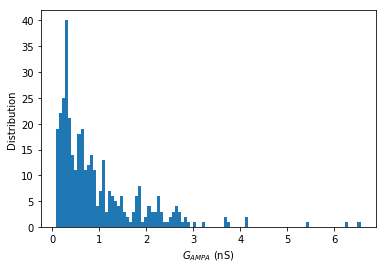

In [28]:
hist(gtrA*spdata['A1']*1000,100)
xlabel('$G_{AMPA}$ (nS)')
ylabel('Distribution')
print('Average AMPA conductance: %.2f nS' % (mean(gtrA*spdata['A1'])/1e-3) )
print('                     std: %.2f nS' % (std(gtrA*spdata['A1'])/1e-3) )

Average NMDA conductance: 0.13 nS
                     std: 0.13 nS


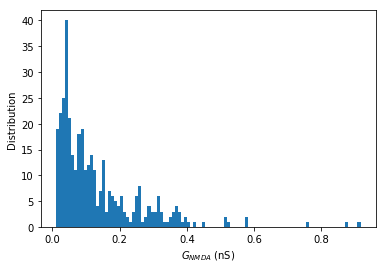

In [29]:
hist(gtrN*spdata['A1']*1000,100)
xlabel('$G_{NMDA}$ (nS)')
ylabel('Distribution')
print('Average NMDA conductance: %.2f nS' % (mean(gtrN*spdata['A1'])/1e-3) )
print('                     std: %.2f nS' % (std(gtrN*spdata['A1'])/1e-3) )

Average GABA conductance: 0.99 nS
                     std: 0.54 nS


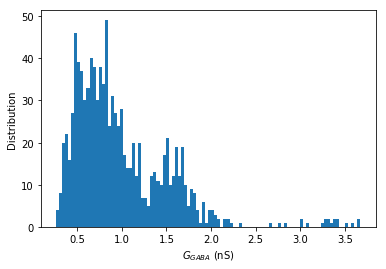

In [30]:
hist(gtrG*iPSDsh*1000,100)
xlabel('$G_{GABA}$ (nS)')
ylabel('Distribution')
print('Average GABA conductance: %.2f nS' % (mean(gtrG*iPSDsh)/1e-3) )
print('                     std: %.2f nS' % (std(gtrG*iPSDsh)/1e-3) )

Time constants used for kinetics

In [31]:
print(AMPA.tau1,AMPA.tau2)
print(NMDA.tau1,NMDA.tau2)
print(GABA.tau1,GABA.tau2)


0.5 3.0
2.0 30.0
1.5 15.0


## Voltage-dependent Currents

## Space parameter 

In [32]:
with open("/mnt/data/spine_dofspace_temp.pickle","rb") as f:
    factorsf,temp = pickle.load(f) 

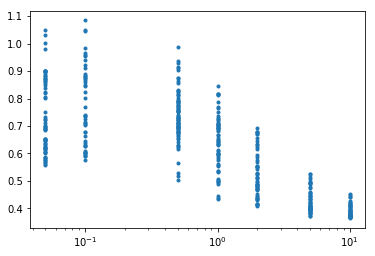

In [33]:
sel = (factorsf[:,0] == 0.5)
plot(factorsf[sel,3],temp[sel,2],'.')
xscale('log')

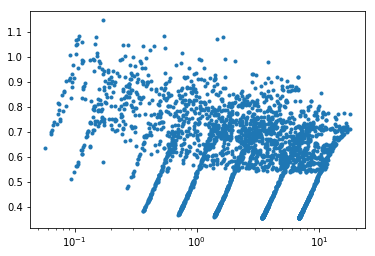

In [34]:
plot(temp[:,1],temp[:,2],'.')
xscale('log')

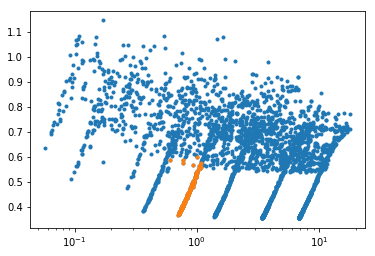

In [35]:
plot(temp[:,1],temp[:,2],'.')
sel = (abs(temp[:,1]-0.834)<0.25)*(temp[:,2]<0.6)
plot(temp[sel,1],temp[sel,2],'.')
xscale('log')


In [37]:
labels = ['GAmpa','GNmda','dend imp','Neck resistance','second dend comp','taum']


Text(0, 0.5, 'CV Calcium')

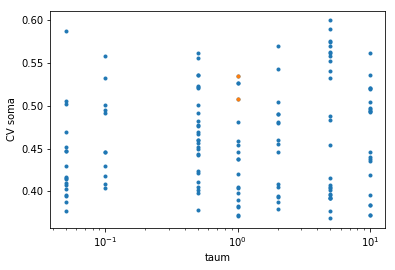

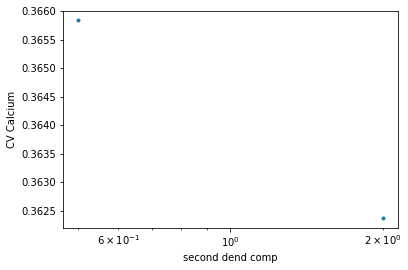

In [38]:
plot(factorsf[sel,5],temp[sel,2],'.')
sel2 = sel*(factorsf[:,5]==1.0)*(factorsf[:,0]==.5)
plot(factorsf[sel2,5],temp[sel2,2],'.')
xlabel(labels[5])
xscale('log')
ylabel('CV soma')
figure()
plot(factorsf[sel2,4],temp[sel2,5],'.')
xscale('log')
xlabel(labels[4])
ylabel('CV Calcium')

In [39]:
rand(4)

array([0.34195739, 0.11012465, 0.55832952, 0.20488796])

In [40]:
factorsf[sel2,:]

array([[0.5 , 2.  , 0.05, 1.  , 0.5 , 1.  ],
       [0.5 , 0.5 , 0.1 , 1.  , 2.  , 1.  ]])

In [102]:
with open("/mnt/data/spine_dofspace2_temp.pickle","rb") as f:
    factorsf,temp = pickle.load(f) 

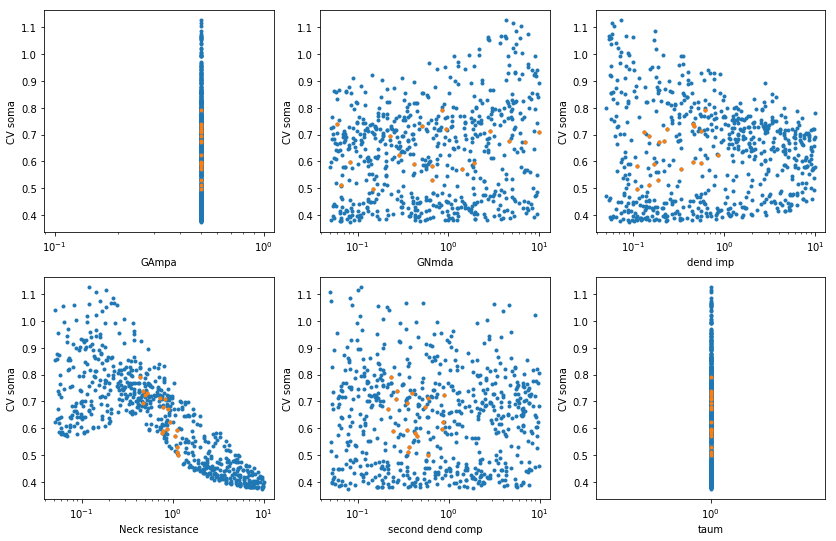

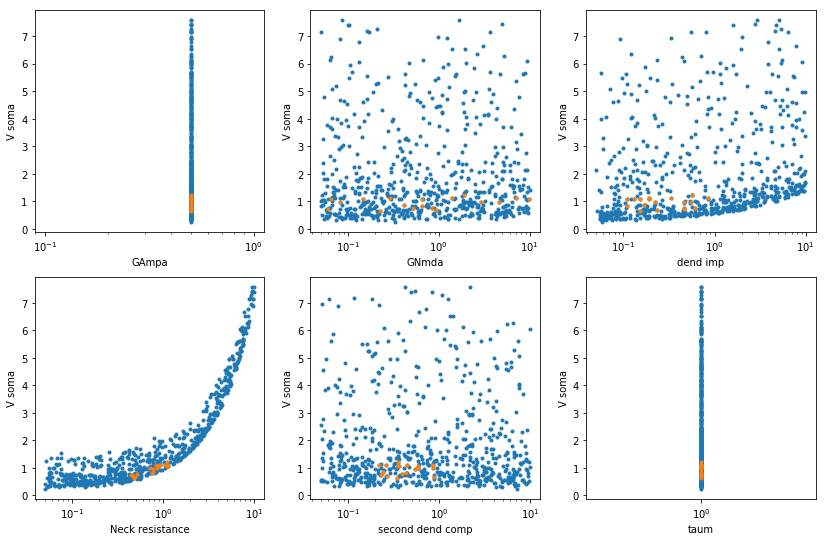

In [103]:
#sel = (temp[:,1]<1)*(temp[:,2]<0.6)*(abs(log10(factorsf[:,3]))<0.50)
sel = (abs(factorsf[:,3]-0.8)<0.4)*(abs(factorsf[:,2]-0.5)<0.4)*(abs(factorsf[:,4]-.60)<0.4)

i = 3
fig, ax = subplots(nrows=2,ncols=3,figsize=(14,9))
for i in range(6):
    ax[i//3,i%3].plot(factorsf[:,i],temp[:,2],'.')
    ax[i//3,i%3].plot(factorsf[sel,i],temp[sel,2],'.')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_ylabel('CV soma')
    ax[i//3,i%3].set_xlabel(labels[i])

fig, ax = subplots(nrows=2,ncols=3,figsize=(14,9))
for i in range(6):
    ax[i//3,i%3].plot(factorsf[:,i],temp[:,1],'.')
    ax[i//3,i%3].plot(factorsf[sel,i],temp[sel,1],'.')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_ylabel('V soma')
    ax[i//3,i%3].set_xlabel(labels[i])


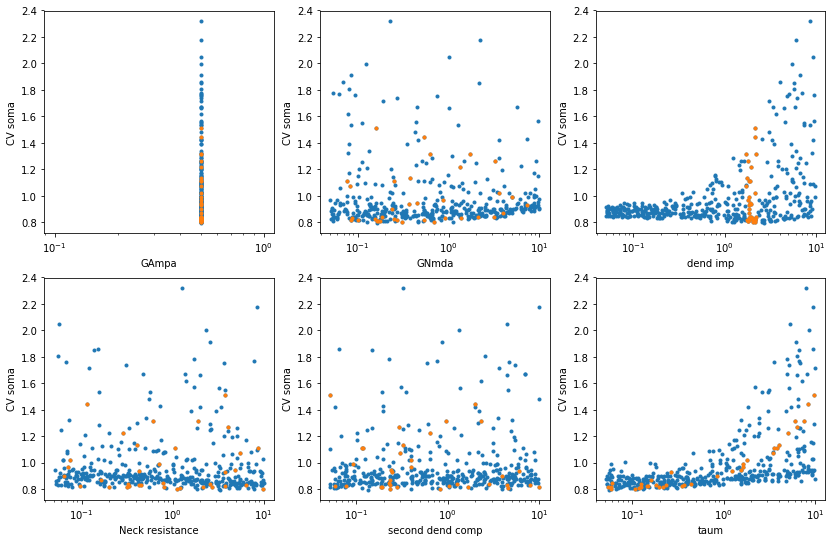

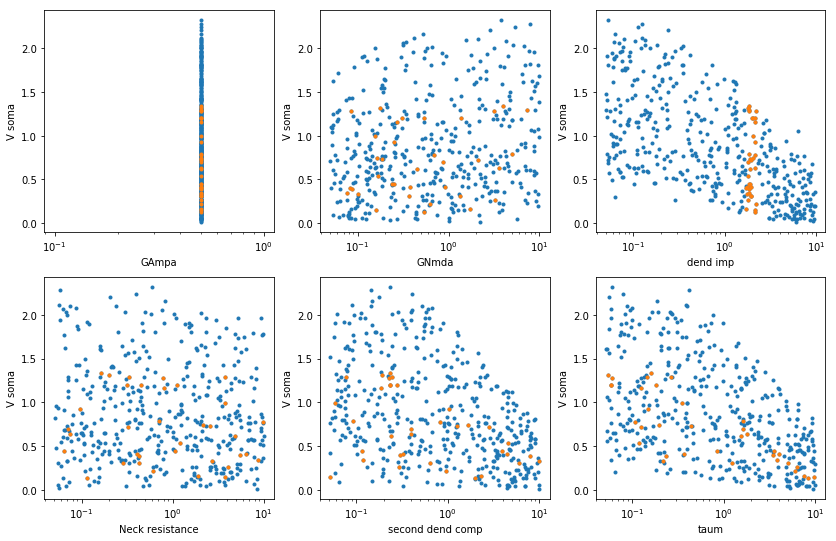

In [141]:
with open("/mnt/data/spine_dofspace_temp.pickle","rb") as f:
    factorsf,temp = pickle.load(f) 
#sel = (temp[:,1]<1)*(temp[:,2]<0.6)*(abs(log10(factorsf[:,3]))<0.50)
#sel = (abs(factorsf[:,3]-0.8)<0.4)*(abs(factorsf[:,2]-0.5)<0.4)*(abs(factorsf[:,4]-.60)<0.4)
sel = (abs(factorsf[:,2]-2.0)<0.3)#*(abs(factorsf[:,5]-3.0)<0.5)
i = 3
fig, ax = subplots(nrows=2,ncols=3,figsize=(14,9))
for i in range(6):
    ax[i//3,i%3].plot(factorsf[:,i],temp[:,2],'.')
    ax[i//3,i%3].plot(factorsf[sel,i],temp[sel,2],'.')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_ylabel('CV soma')
    ax[i//3,i%3].set_xlabel(labels[i])

fig, ax = subplots(nrows=2,ncols=3,figsize=(14,9))
for i in range(6):
    ax[i//3,i%3].plot(factorsf[:,i],temp[:,1],'.')
    ax[i//3,i%3].plot(factorsf[sel,i],temp[sel,1],'.')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_ylabel('V soma')
    ax[i//3,i%3].set_xlabel(labels[i])


(array([ 8., 10., 22., 19., 23., 23., 25., 27., 19., 21., 20., 23., 18.,
        18., 12., 11., 11., 13.,  6.,  9.,  6.,  3.,  5.,  4.,  1.,  2.,
         3.,  1.,  1.,  0.,  1.]),
 array([0.22223806, 0.32729396, 0.43234986, 0.53740576, 0.64246167,
        0.74751757, 0.85257347, 0.95762938, 1.06268528, 1.16774118,
        1.27279708, 1.37785299, 1.48290889, 1.58796479, 1.69302069,
        1.7980766 , 1.9031325 , 2.0081884 , 2.11324431, 2.21830021,
        2.32335611, 2.42841201, 2.53346792, 2.63852382, 2.74357972,
        2.84863562, 2.95369153, 3.05874743, 3.16380333, 3.26885923,
        3.37391514, 3.47897104]),
 <a list of 31 Patch objects>)

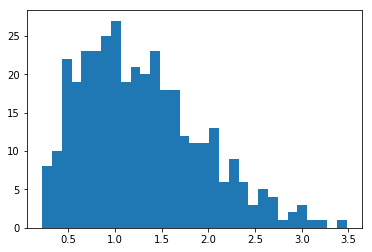

In [140]:
hist(spdata['Lneck'],31)

In [112]:
factorsf[sel,:]
temp[sel,:]

29.78380012512207

In [100]:
with open("/mnt/data/spine_dofspace3_temp.pickle","rb") as f:
    factorsf,temp = pickle.load(f) 

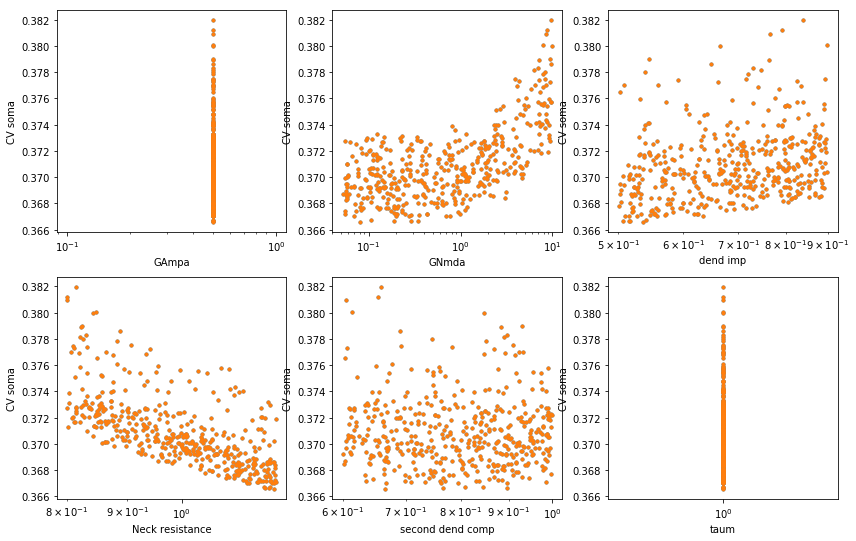

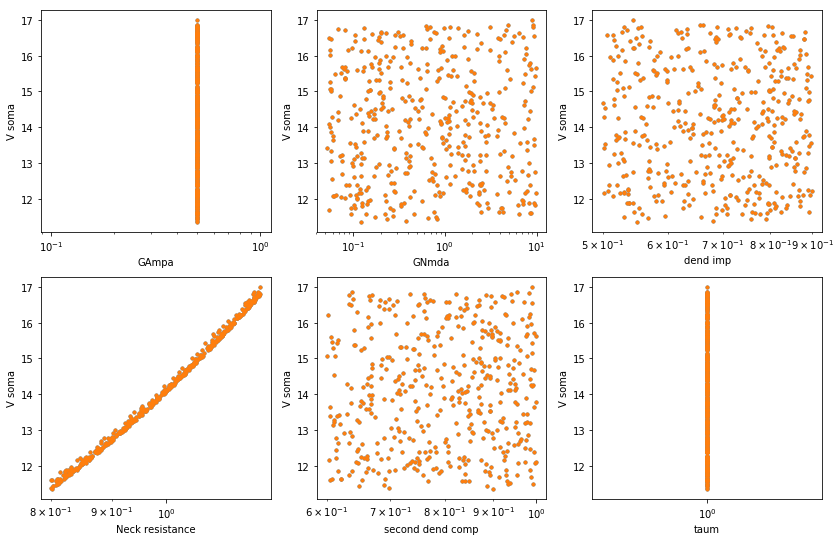

In [101]:
#sel = (temp[:,1]<1)*(temp[:,2]<0.6)*(abs(log10(factorsf[:,3]))<0.50)
sel = (abs(factorsf[:,3]-0.8)<0.4)*(abs(factorsf[:,2]-0.5)<0.4)*(abs(factorsf[:,4]-.60)<0.4)

i = 3
fig, ax = subplots(nrows=2,ncols=3,figsize=(14,9))
for i in range(6):
    ax[i//3,i%3].plot(factorsf[:,i],temp[:,2],'.')
    ax[i//3,i%3].plot(factorsf[sel,i],temp[sel,2],'.')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_ylabel('CV soma')
    ax[i//3,i%3].set_xlabel(labels[i])

fig, ax = subplots(nrows=2,ncols=3,figsize=(14,9))
for i in range(6):
    ax[i//3,i%3].plot(factorsf[:,i],temp[:,1],'.')
    ax[i//3,i%3].plot(factorsf[sel,i],temp[sel,1],'.')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_ylabel('V soma')
    ax[i//3,i%3].set_xlabel(labels[i])


In [83]:
def getint(x):
    xc = array(x)*1.0
    xc.sort()
    sh = xc.shape[0]
    xmed = xc[sh//2]
    s0= int(sh*(1-.6827)/2)
    s1 = sh-s0
    x0 = xc[s0]
    x1 = xc[s1]
    s0b= int(sh*(1-.95)/2)
    s1b = sh-s0b
    x0b = xc[s0b]
    x1b = xc[s1b]
    return((xmed,x0b,x1b))

Head Volume 0.057 um^3 (0.011 - 0.376 )
Head Area 2.411 um^2 (0.728 - 8.368 )
PSD 0.096 um^2 (0.018 - 0.488 )
minimum D neck nm 113.932 (50.849 - 364.206 )
avg D neck 227.707 nm (122.725 - 481.297 )


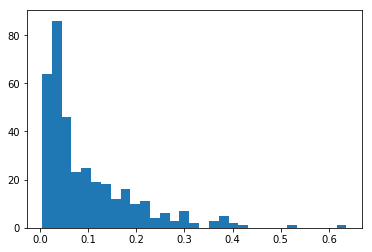

In [87]:
spt = spdata
hist(spt['Vh'],31)
print('Head Volume %.3f um^3 (%.3f - %.3f )' % getint(1.0*spt['Vh']))
print('Head Area %.3f um^2 (%.3f - %.3f )' %getint(1.0*spt['Ah']))
print('PSD %.3f um^2 (%.3f - %.3f )' %getint(1.0*spt['A1']))
print('minimum D neck nm %.3f (%.3f - %.3f )' % getint(1.0*spt['minDneck']))
print('avg D neck %.3f nm (%.3f - %.3f )' % getint(1.0*spt['meanDneck']))


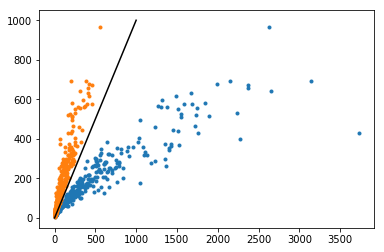

In [81]:
plot(2.5*(spt['Lneck']*1e-6)/(spt['minDneck']*1e-9)**2/1e6,spt['Rneck'],'.')
plot(2.5*(spt['Lneck']*1e-6)/(spt['meanDneck']*1e-9)**2/1e6,spt['Rneck'],'.')
plot(linspace(0,1000),linspace(0,1000),'k-')

(array([ 93., 105.,  48.,  38.,  38.,  19.,  11.,   9.,   2.,   2.]),
 array([ 0.44218282,  1.53671793,  2.63125303,  3.72578814,  4.82032325,
         5.91485835,  7.00939346,  8.10392857,  9.19846367, 10.29299878,
        11.38753389]),
 <a list of 10 Patch objects>)

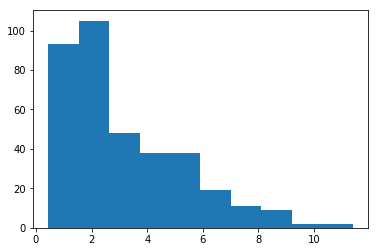

In [63]:
hist(spdata['Ah'])

In [96]:
x = [0.18,0.2,0.23,0.27,0.29,0.34,0.42,0.48,0.54,0.54,0.59,0.63,0.635,0.65,0.73,0.83,0.93,0.94,1.02,1.38]

In [99]:
mean(x),std(x)

(0.5912499999999999, 0.3067730227709079)

In [98]:
iPSDsh.mean()

0.16447755821029825